In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 20})
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [3]:
Nor_path = "./Dataset/Normal_mixed.csv"
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
                "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
Nor_df = pd.read_csv(Nor_path, header=None,names= col_names, nrows= 100000)

In [4]:
Abnor_path = "./Dataset/Abnormal.csv"
Abnor_df = pd.read_csv(Abnor_path, header=None,names= col_names, nrows= 100000)

In [ ]:
Kdd_path = "./Dataset/kdd99_extracted.csv"
kdd99_df = pd.read_csv(Kdd_path, header=None,names= col_names, nrows= 200000)

In [ ]:
kdd99_nor = kdd99_df[kdd99_df['label'] == 'Normal']
kdd99_abnor = kdd99_df[kdd99_df['label'] != 'Normal']

In [5]:
Train = pd.concat([Nor_df.iloc[:8000],Abnor_df.iloc[:8000]], ignore_index=True)
Train_nor = Nor_df.iloc[:8000]
#Train_abnor = pd.concat([Abnor_df.iloc[:8000], kdd99_abnor.iloc[:4000]], ignore_index=True)
Train_abnor = Abnor_df.iloc[:8000]

Test = pd.concat([Nor_df.iloc[-2000:], Abnor_df.iloc[-2000:]], ignore_index=True)
Test_nor = Nor_df.iloc[-2000:]
Test_abnor = Abnor_df.iloc[-2000:]

# Test_kdd = pd.concat([kdd99_nor.iloc[:2000],kdd99_abnor.iloc[:2000]], ignore_index=True)
# Test_nor_kdd = kdd99_nor.iloc[:2000]
# Test_abnor_kdd = kdd99_abnor.iloc[:2000]


In [6]:
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler()

In [7]:
def preprocess(df, is_fit=True):
    # chuyển normal thành 1 và các lớp khác thành 0
    label = df['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)

    # loại bỏ cột dữ liệu không cần thiết
    df.drop(["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"], axis=1)

    # chia dữ liệu ra số, chữ để tiện xử lý
    numerical_data = df.select_dtypes(exclude='object').values
    categorical_data = df.select_dtypes(include='object').values

    # chỉ fit với dữ liệu train
    if is_fit:
        encoder.fit(categorical_data)

    # chuyển từ dữ liệu chữ sang onehot
    categorical_data = encoder.transform(categorical_data).toarray()

    # nối dữ liệu số và onehot lại
    data = np.concatenate([numerical_data, categorical_data], axis=1)

    # chỉ fit với dữ liệu train
    if is_fit:
        scaler.fit(data)

    # dữ liệu chuẩn hóa về dạng [0, 1]
    data = scaler.transform(data)

    return dict(data=data, label=label)

In [8]:
# xử lý dữ liệu
train = preprocess(Train, True)
test = preprocess(Test, False)
#test_kdd = preprocess(Test_kdd, False)
#test_v1 = preprocess(Test_v1, False)
#test_v2 = preprocess(Test_v2,False)

In [9]:
train['data'].shape, test['data'].shape

((16000, 51), (4000, 51))

In [10]:
# chia dữ liệu
Train_nor = train['data'][train['label'] == 'Normal']
Train_abnor = train['data'][train['label'] == 'Abnormal']

Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

# kdd_nor = test_kdd['data'][test_kdd['label'] == 'Normal']
# kdd_abnor = test_kdd['data'][test_kdd['label'] == 'Abnormal']

In [11]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(48, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(8, activation='tanh')
    ])
    self.decoder = keras.Sequential([
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(48, activation='tanh'),
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(input_dim, activation='sigmoid'),
    ])

  def call(self, x):
    code = self.encoder(x)
    r = self.decoder(code)
    return r

  def get_reconstruction_error(self, x):
    r = self.predict(x)
    return keras.metrics.mean_squared_error(x, r)

  def predict_class(self, x, threshold):
    reconstruction_error = self.get_reconstruction_error(x)
    return np.where(reconstruction_error <= threshold, 'Normal', 'Abnormal')

In [12]:
model = Autoencoder(Train_nor.shape[1])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer, loss_fn)

In [13]:
model.fit(Train_nor, Train_nor, batch_size=64, epochs=200, shuffle=True)

Epoch 1/200
125/125 [==============================] - 2s 2ms/step - loss: 0.2144
Epoch 2/200
125/125 [==============================] - 0s 2ms/step - loss: 0.1380
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0799
Epoch 4/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0615
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0557
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0532
Epoch 7/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0519
Epoch 8/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0510
Epoch 9/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0492
Epoch 10/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0462
Epoch 11/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 12/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0400
Epoch 13/200


In [14]:
train_normal_re = model.get_reconstruction_error(Train_nor)
train_abnormal_re = model.get_reconstruction_error(Train_abnor)

test_normal_re = model.get_reconstruction_error(Test_nor)
test_abnormal_re = model.get_reconstruction_error(Test_abnor)

# kdd_nor_re = model.get_reconstruction_error(kdd_nor)
# kdd_abnor_re = model.get_reconstruction_error(kdd_abnor)

63/63 [==============================] - 0s 1ms/step


In [15]:
alpha = 0.5
threshold = np.concatenate([train_normal_re, train_abnormal_re]).mean() * alpha
print('Ngưỡng vừa tìm được từ tập train:', threshold)

Ngưỡng vừa tìm được từ tập train: 0.015223712660372257


In [ ]:
label_predict = model.predict_class(train['data'], threshold)
print('Độ chính xác tập huấn luyện', end=': ')
print(accuracy_score(train['label'], label_predict))

label_predict = model.predict_class(test['data'], threshold)
print('Độ chính xác tập test', end=': ')
print(accuracy_score(test['label'], label_predict))

# label_predict = model.predict_class(test_kdd['data'], threshold)
# print('Độ chính xác tập kdd', end=': ')
# print(accuracy_score(test_kdd['label'], label_predict))

191/500 [==========>...................] - ETA: 0s

500/500 [==============================] - 1s 1ms/step
Độ chính xác tập huấn luyện: 0.9990625
125/125 [==============================] - 0s 1ms/step
Độ chính xác tập test: 0.99775


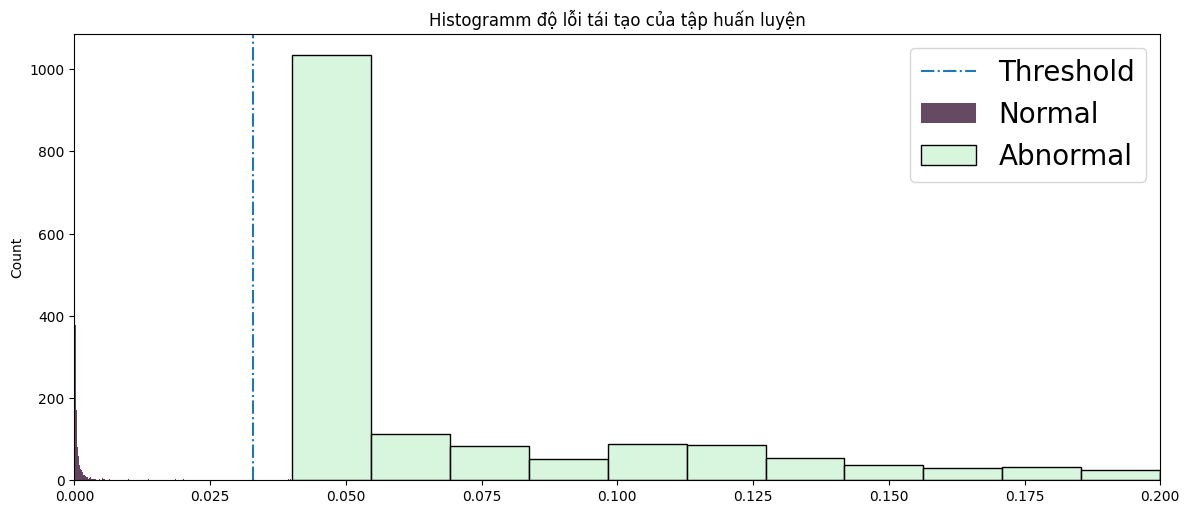

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=test_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=test_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.2])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện')
plt.show()

# Reinforcement Learning A2C threshold adaption


In [ ]:
#Agent tự động tăng hoặc giảm hoặc giữ nguyên => cần được train
#Train Agent dựa trên hiệu suất phân loại normal và abnormal
#Reward, Action, Agent
#Tạo environment: update_state, reset, act, get_states

In [16]:
#import gym
from gym import Env
from gym.spaces import Box, Discrete
import random
from collections import deque

In [113]:
class RLenv(Env):
    def __init__(self, data, true_label, init_threshold):
        super(RLenv,self).__init__()

        self.normal_data = data
        #self.abnormal_data = abnormal
        self.true_label = true_label
        self.threshold = init_threshold
        self.action_space = Discrete(3) #3 actions: increase, decrease, keep
        self.observation_space = Box(low=0 , high=1, shape= (len(data[0]), ) )
        self.current_step = 0
        self.done = False
        self.random_index = np.random.randint(len(self.normal_data))

    def rand(self):
        return np.random.randint(len(self.normal_data))
    
    #self.random_index = np.random.randint(len(self.normal_data))

    def reset(self):
        self.current_step = 0
        self.done = False
        #random_index = np.random.randint(len(self.normal_data))
        init_state = self.normal_data[self.random_index]
        # x_tensor = tf.convert_to_tensor(init_state, dtype=tf.float32)
        return init_state

    def step(self, action):
        assert self.action_space.contains(action)

        if action == 0:
            self.threshold += 0.01
        elif action == 2:
            self.threshold -= 0.01
        else: self.threshold = self.threshold

        state = self.normal_data[self.current_step]
        state = np.expand_dims(state, axis=0) 
        reward = self.get_reward(state)

        self.current_step += 1
        if self.current_step >= 200:
            self.done = True
    
        return state, reward, self.done, {}
    
    def get_reward(self, state): 
        reconstruction_err = model.get_reconstruction_error(state)
        predict_class = np.where(reconstruction_err <= self.threshold, 'Normal', 'Abnormal')
        if predict_class == self.true_label[self.random_index]:
            reward = 1.0
        elif predict_class != self.true_label[self.random_index]:
            reward = 0.0

        return reward
    
    def render(self, mode='human'):
        if mode == 'human':
            print("Current Threshold:", self.threshold)
            print("Current State:", self.normal_data[self.current_step])
            


In [22]:
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.dqn = self.build_model()

    def build_model(self):
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(27, input_dim=self.state_size, activation='relu'))
        model.add(keras.layers.Dense(27, activation='relu'))
        model.add(keras.layers.Dense(9, activation='relu'))
        model.add(keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam())
        return model        
        

    def predict(self, state):
        return self.dqn.predict(state)

    def fit(self, state, target):
        return self.dqn.fit(state, target, epochs= 1, verbose= 0)
    

In [19]:
class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Hệ số giảm sau mỗi bước
        self.epsilon = 1.0  # Khả năng thực hiện hành động ngẫu nhiên
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.dqn = DQN(state_size, action_size)

    def remember(self, action, reward, state, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_val = self.dqn.predict(state)
        return np.argmax(act_val[0])
        
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.dqn.predict(next_state)[0])
            target_f = self.dqn.predict(state)
            target_f[0][action] = target
            self.dqn.fit(state, target_f)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [112]:
init_threshold = threshold
env = RLenv(train['data'],train['label'], init_threshold)
state_size = env.observation_space.shape[0]
action_size = 3
agent = Agent(state_size, action_size)

# Các tham số huấn luyện
episodes = 200
batch_size = 64
max_steps_per_episode = 64

for episode in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    for step in range(max_steps_per_episode):
        # print(step)
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        agent.remember(action, reward, state, next_state, done)
        state = next_state
        
        if done:
            break
        print(done)
        if len(agent.memory) >= batch_size:
            agent.replay(batch_size)
    
    print(f"Episode: {episode + 1}/{episodes}, Total Steps: {step + 1}, Total Reward: {total_reward:.2f}, Threshold: {env.threshold:.4f}")

# Lưu mạng nơ-ron sau khi huấn luyện (tuỳ chọn)
agent.dqn.dqn.save('trained_dqn_model.h5')
print("Model Saved")


1/1 [==============================] - 0s 22ms/step
False
1/1 [==============================] - 0s 22ms/step
False
1/1 [==============================] - 0s 22ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 21ms/step
False
1/1 [==============================] - 0s 21ms/step
False
1/1 [==============================] - 0s 23ms/step
False
1/1 [==============================] - 0s 24ms/step
False
1/1 [==============================] - 0s 23ms/step
False
1/1 [==============================] - 0s 22ms/step
False
1/1 [==============================] - 0s 22ms/step
False
1/1 [==============================] - 0s 23ms/step
False
1/1 [==============================] - 0s 22ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 22ms/step
False
1/1 [=========

KeyboardInterrupt: 